In [1]:
%%bash
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip -O Datasets/ChestAccel.zip
cd Datasets
unzip ChestAccel.zip
mv "Activity Recognition from Single Chest-Mounted Accelerometer" ChestAccel

Archive:  ChestAccel.zip


--2016-11-14 10:25:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11256835 (11M) [application/zip]
Saving to: ‘Datasets/ChestAccel.zip’

     0K .......... .......... .......... .......... ..........  0%  211K 52s
    50K .......... .......... .......... .......... ..........  0%  329K 42s
   100K .......... .......... .......... .......... ..........  1%  621K 34s
   150K .......... .......... .......... .......... ..........  1%  687K 29s
   200K .......... .......... .......... .......... ..........  2%  645K 27s
   250K .......... .......... .......... .......... ..........  2%  645K 25s
   300K .......... .......... .......... .......... ..........  3%  648K 24s
   350K ...

In [2]:
%%bash
ls Datasets/ | grep ChestAccel
cat Datasets/ChestAccel/README

ChestAccel
ChestAccel.zip
1. Title: Activity Recognition from a Single Chest-Mounted Accelerometer
	Updated Nov, 2013 , P. Casale, email: plcasale@ieee.org
	
2. Abstract: The dataset collects data from a wearable accelerometer mounted on the chest. Uncalibrated Accelerometer Data are collected from 15 participants performing 7 activities. The dataset is intended for Activity Recognition research purposes. It provides challenges for identification and authentication of people using motion patterns.

3. Relevant Information:
   --- The dataset collects data from a wearable accelerometer mounted on the chest
   --- Sampling frequency of the accelerometer: 52 Hz
   --- Accelerometer Data are Uncalibrated
   --- Number of Participants: 15
   --- Number of Activities: 7
   --- Data Format: CSV

4. Dataset Information
   --- Data are separated by participant
   --- Each file contains the following information
       ---- sequential number, x acceleration, y acceleration, z acceleration, label

In [3]:
%matplotlib inline
import ggplot as gg
from ggplot import ggplot, aes, geom_line, facet_wrap

import os
import pandas as pd

import numpy as np

from thinkbayes2 import Suite, Joint, EvalNormalPdf

from itertools import product

In [4]:
df = pd.read_csv('Datasets/ChestAccel/2.csv',  
                 names=["seq_num", "x_ddot", "y_ddot", "z_ddot", "label"])
behavior = {0:"Unspecified",
            1:"Working at Computer",
            2:"Standing Up, Walking and Going up\down stairs",
            3:"Standing",
            4:"Walking",
            5:"Going Up\Down Stairs",
            6:"Walking and Talking with Someone",
            7:"Talking while Standing"}
behavior_inv = {v:k for k, v in behavior.items()}
df.label = [behavior[int(n)] for n in df.label]
print(len(df))
df.head()

138001


,seq_num,x_ddot,y_ddot,z_ddot,label
0,0.0,1984,1998,1645,Working at Computer
1,1.0,1984,2003,1653,Working at Computer
2,2.0,1987,2002,1648,Working at Computer
3,3.0,1990,2001,1650,Working at Computer
4,4.0,1992,2000,1657,Working at Computer


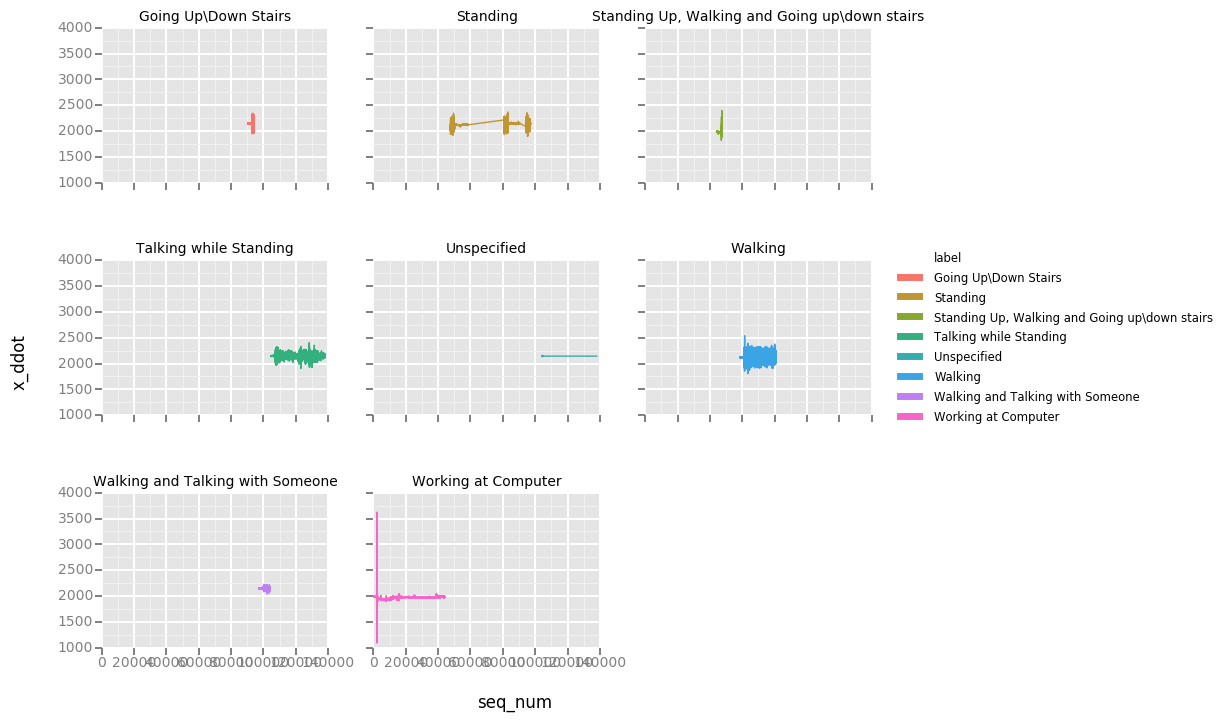

<ggplot: (8751698495608)>

In [5]:
g = ggplot(df, aes(x="seq_num",
                   y="x_ddot",
                   color="label")) +\
    geom_line() +\
    facet_wrap("label")
    
g

In [6]:
class NormalClassifier(Suite, Joint):
    def __init__(self, prior=None, norm_param=None):
        self.norm_param = norm_param
        Suite.__init__(self, prior)
        
    def Likelihood(self, data, hypo):
        data = data[1]
        activity = hypo
        likes = []
        for accel in data.keys():
            if not accel.endswith('ddot'):
                continue
            likes.append(EvalNormalPdf(data[accel], *self.norm_param[activity][accel]))
        return np.sum(likes)
    
def MakeColNormals(df, groupby="label", norm_cols=['x_ddot', 'y_ddot', 'z_ddot']):
    mu_sigma = {}
    for l, cols_df in df.groupby(groupby):
        mu_sigma[l] = {}
        for col in cols_df.columns:
            if col not in norm_cols:
                continue

            accel_df = pd.DataFrame(cols_df[col])
            mu, sigma = (np.average(accel_df[col]), np.std(accel_df[col]))
            mu_sigma[l][col] = (mu, sigma)
    return mu_sigma

def predict(df, train_rows=None, test_rows=None, n_samples=40):
    if train_rows == None:
        norms = MakeColNormals(df)
    else:
        norms = MakeColNormals(df.loc[[train_rows]])
        
    if test_rows == None:
        category = np.random.choice(list(behavior.keys()))
        test_df = df[df.label==behavior[category]].head(n_samples)
        
    else:
        test_df = df.loc[[test_rows]]
        
    trained_classifier = NormalClassifier(prior=behavior_inv.keys(), norm_param=norms)
    trained_classifier.UpdateSet(test_df.iterrows())
    trained_classifier.Normalize()
    return (behavior[category], trained_classifier)

In [12]:
ans, pred = predict(df)
print("Expected outcome: ", ans)
pred.Print()

Expected outcome:  Standing
Going Up\Down Stairs 0.00468484412267
Standing 0.949096059227
Standing Up, Walking and Going up\down stairs 1.3961125476e-24
Talking while Standing 0.046216183114
Unspecified 0.0
Walking 2.91353676648e-06
Walking and Talking with Someone 2.09215639526e-18
Working at Computer 4.48628716107e-29
